# Bootstrap the RUV metric and display on a value diagram 

In [78]:
# Copyright 2023 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [79]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import bootstrap
import pickle
import bz2
import time

sys.path.append('..')

from ruv.relative_utility_value import *
from ruv.damage_functions import *
from ruv.economic_models import *
from ruv.utility_functions import *

In [80]:
plt.rcParams['figure.figsize'] = (8, 7)

plt.rcParams['font.family'] = "calibri"
plt.rcParams['font.size'] = "12.5"

colors = {
    'black': '#000000',
    'light_orange': '#E69F00',
    'light_blue': '#56B4E9',
    'green': '#009E73',
    'yellow': '#F0E442',
    'dark_blue': '#0072B2',
    'dark_orange': '#D55E00',
    'pink': '#CC79A7'
} 

# Example forecast dataset
### 7th day ahead forecast for Murray at Biggara (401012) generated using the MuTHRE method

In [96]:
dataset_filepath = 'example_data.pickle.bz2'
parallel_nodes = 8
alpha_step = 0.02
bootstrap_samples = 100

In [97]:
with bz2.BZ2File(dataset_filepath, 'r') as f:
    data = pickle.load(f)
obs, clim_ens, fcst_ens = data['obs'], data['clim'].T, data['fcst'].T
print(obs.shape, fcst_ens.shape, clim_ens.shape)

(276,) (276, 100) (276, 496)


# Define decision context

In [99]:
decision_definition = {
    'alphas': np.arange(alpha_step, 1, alpha_step),
    'damage_function': [binary, {'max_loss': 1, 'min_loss': 0, 'threshold': 0.75}],
    'utility_function': [cara, {'A': 0}],
    'economic_model': [cost_loss, cost_loss_analytical_spend],
    'decision_thresholds': np.nanquantile(obs, [0, 0.75])
}

# 'decision_method' defaults to 'optimise_over_forecast_distribution'

ref = None  # use event frequency as the reference forecast

# Calculate RUV using optimisation decision-making method

In [100]:
start = time.time()
results_optim = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes=parallel_nodes)
end = time.time()

# Bootstrap the RUV calculation

In [101]:
def bootstrap_ruv(indices):
    global count; count += 1
    if count % 5 == 0:
        print('Bootstrap sample: %d' % count)
    return relative_utility_value(obs[indices], fcst_ens[indices], ref, decision_definition, parallel_nodes=parallel_nodes)['ruv']

In [ ]:
time_estimate = (end - start) * bootstrap_samples / 60
print('Bootstrap will take approximatly %f.2 minutes' % time_estimate)

In [103]:
count = 0
indices = [np.arange(len(obs))]
results_bootstrap = bootstrap(indices, bootstrap_ruv, n_resamples=bootstrap_samples, confidence_level=0.95, vectorized=False, method='percentile')

Bootstrap sample: 5
Bootstrap sample: 10
Bootstrap sample: 15
Bootstrap sample: 20
Bootstrap sample: 25
Bootstrap sample: 30
Bootstrap sample: 35
Bootstrap sample: 40
Bootstrap sample: 45
Bootstrap sample: 50
Bootstrap sample: 55
Bootstrap sample: 60
Bootstrap sample: 65
Bootstrap sample: 70
Bootstrap sample: 75
Bootstrap sample: 80
Bootstrap sample: 85
Bootstrap sample: 90
Bootstrap sample: 95
Bootstrap sample: 100


# Plot results on a value diagram

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


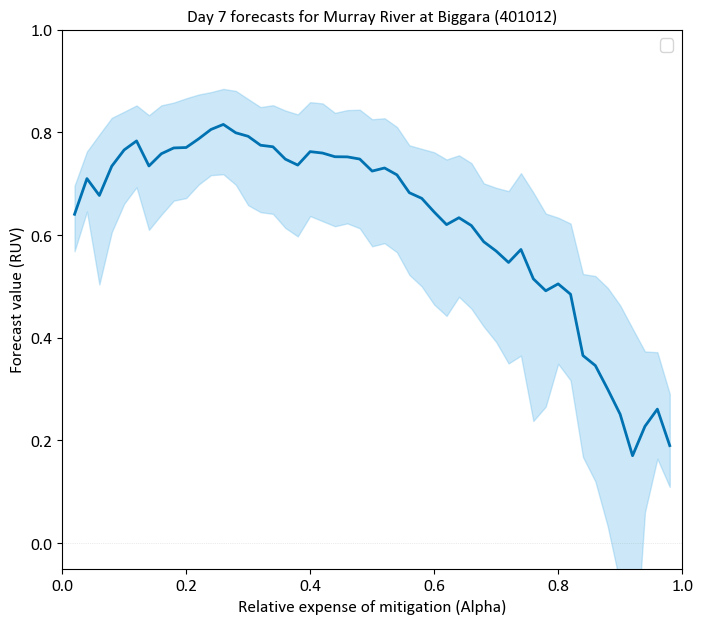

In [104]:
plt.plot(decision_definition['alphas'], results_optim['ruv'], color=colors['dark_blue'], linewidth=2, alpha=1.0)
plt.fill_between(decision_definition['alphas'], results_bootstrap.confidence_interval.low, results_bootstrap.confidence_interval.high, color=colors['light_blue'], alpha=0.3)
plt.axhline(0, color='grey', linewidth=0.5, alpha=0.3, linestyle='dotted')
plt.xlim((0, 1))
plt.ylim(-0.05, 1)
plt.xlabel('Relative expense of mitigation (Alpha)')
plt.ylabel('Forecast value (RUV)')
plt.title('Day 7 forecasts for Murray River at Biggara (401012)', fontsize='medium')
plt.legend()